## Imports

In [7]:
import sys
sys.path.append('../../')
import numpy as np
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
import tqdm
from PIL import Image, ImageOps
import matplotlib.patches as patches
from scipy.spatial.transform import Rotation
import pandas as pd
from scipy.spatial import distance
import time
import os
import math
import scipy.io as sio
from utils.renderer import Renderer
from utils.image_operations import expand_bbox_rectangle
from utils.pose_operations import get_pose
from img2pose import img2poseModel
from model_loader import load_model

np.set_printoptions(suppress=True)

## Declare useful functions

In [2]:
def render_plot(img, poses, bboxes):
    (w, h) = img.size
    image_intrinsics = np.array([[w + h, 0, w // 2], [0, w + h, h // 2], [0, 0, 1]])
    
    trans_vertices = renderer.transform_vertices(img, poses)
    img = renderer.render(img, trans_vertices, alpha=1)    

    plt.figure(figsize=(8, 8))     
    
    for bbox in bboxes:
        plt.gca().add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],linewidth=3,edgecolor='b',facecolor='none'))            
    
    plt.imshow(img)        
    plt.show()

## Create the renderer for visualization

In [3]:
renderer = Renderer(
    vertices_path="../../pose_references/vertices_trans.npy", 
    triangles_path="../../pose_references/triangles.npy"
)

threed_points = np.load('../../pose_references/reference_3d_68_points_trans.npy')

## Load model weights and pose mean and std deviation
To test other models, change MODEL_PATH along the the POSE_MEAN and POSE_STDDEV used for training

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

DEPTH = 18
MAX_SIZE = 1400
MIN_SIZE = 600

POSE_MEAN = "../../models/WIDER_train_pose_mean_v1.npy"
POSE_STDDEV = "../../models/WIDER_train_pose_stddev_v1.npy"
MODEL_PATH = "../../models/img2pose_v1.pth"

pose_mean = np.load(POSE_MEAN)
pose_stddev = np.load(POSE_STDDEV)

img2pose_model = img2poseModel(
    DEPTH, MIN_SIZE, MAX_SIZE, 
    pose_mean=pose_mean, pose_stddev=pose_stddev,
    threed_68_points=threed_points,
)
load_model(img2pose_model.fpn_model, MODEL_PATH, cpu_mode=str(img2pose_model.device) == "cpu", model_only=True)
img2pose_model.evaluate()

Model will run on CPU!


## Run on a folder or an image list
Give it a list with images paths, or a folder containing images


  0%|          | 0/11 [00:00<?, ?it/s]Exception ignored in: <bound method tqdm.__del__ of   0%|<bar/>| 0/11 [00:42<?, ?it/s]>
Traceback (most recent call last):
  File "/home/pdd/anaconda3/envs/face3d/lib/python3.6/site-packages/tqdm/std.py", line 1135, in __del__
    self.close()
  File "/home/pdd/anaconda3/envs/face3d/lib/python3.6/site-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


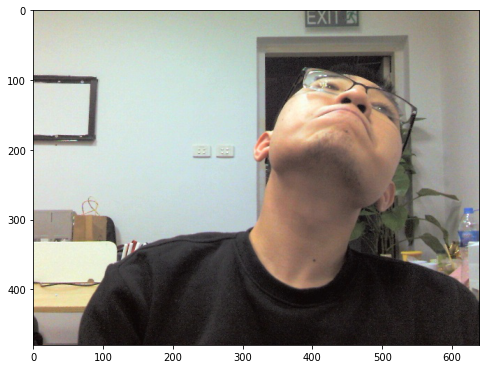


  9%|▉         | 1/11 [00:02<00:28,  2.87s/it]

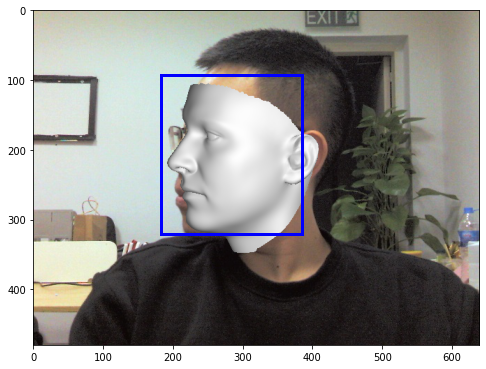


 18%|█▊        | 2/11 [00:05<00:26,  2.93s/it]

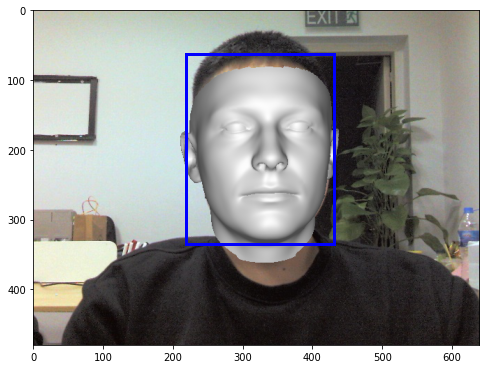


 27%|██▋       | 3/11 [00:08<00:23,  2.91s/it]

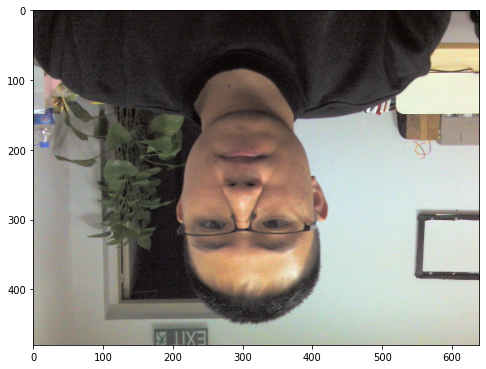


 36%|███▋      | 4/11 [00:11<00:19,  2.79s/it]

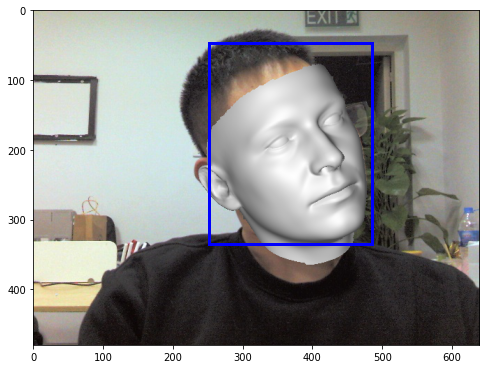


 45%|████▌     | 5/11 [00:14<00:16,  2.77s/it]

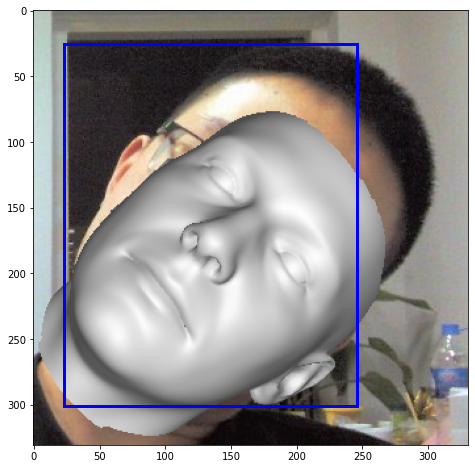


 55%|█████▍    | 6/11 [00:16<00:13,  2.71s/it]

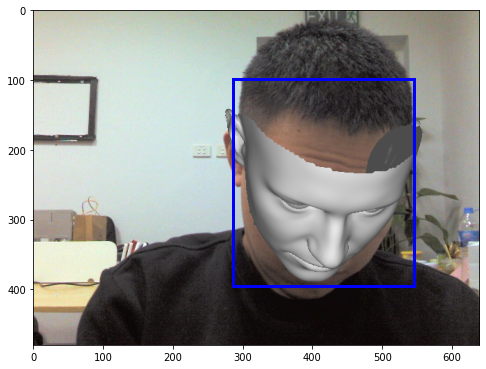


 64%|██████▎   | 7/11 [00:19<00:11,  2.75s/it]

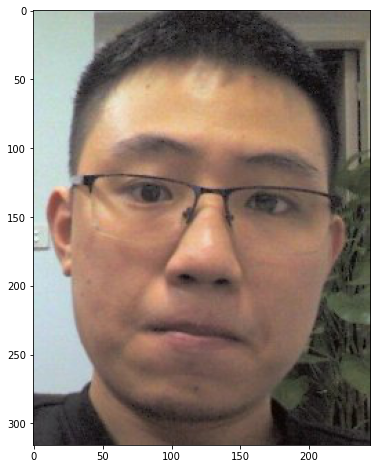


 73%|███████▎  | 8/11 [00:22<00:08,  2.78s/it]

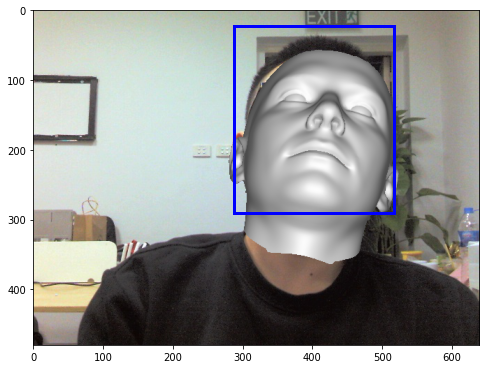


 82%|████████▏ | 9/11 [00:25<00:05,  2.78s/it]

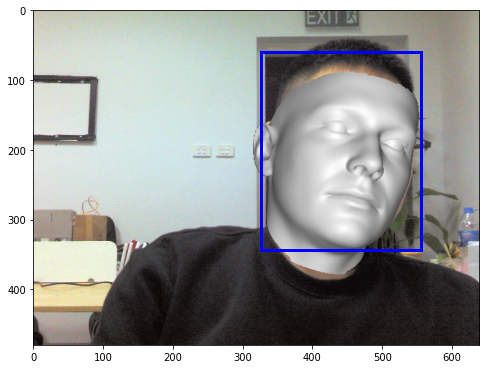


 91%|█████████ | 10/11 [00:27<00:02,  2.79s/it]

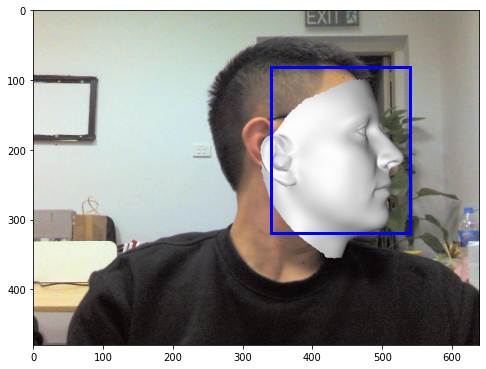


100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


In [8]:
# change to a folder with images, or another list containing image paths
images_path = "/home/pdd/Desktop/workspace/Face-alignment/input"

threshold = 0.9

if os.path.isfile(images_path):
    img_paths = pd.read_csv(images_path, delimiter=" ", header=None)
    img_paths = np.asarray(img_paths).squeeze()
else:
    img_paths = [os.path.join(images_path, img_path) for img_path in os.listdir(images_path)]

for img_path in tqdm.tqdm(img_paths):
    img = Image.open(img_path).convert("RGB")
    
    image_name = os.path.split(img_path)[1]
    
    (w, h) = img.size
    image_intrinsics = np.array([[w + h, 0, w // 2], [0, w + h, h // 2], [0, 0, 1]])
            
    res = img2pose_model.predict([transform(img)])[0]

    all_bboxes = res["boxes"].cpu().numpy().astype('float')

    poses = []
    bboxes = []
    for i in range(len(all_bboxes)):
        if res["scores"][i] > threshold:
            bbox = all_bboxes[i]
            pose_pred = res["dofs"].cpu().numpy()[i].astype('float')
            pose_pred = pose_pred.squeeze()

            poses.append(pose_pred)  
            bboxes.append(bbox)

    render_plot(img.copy(), poses, bboxes)